In [1]:
import shutil
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from datetime import date
import pandas as pd
import os
import rasterio
import cv2
import matplotlib.pyplot as plt
import itertools
import rasterio
from rasterio.plot import show

In [62]:
image_folder = 'S2A_MSIL2A_20220725T093041_N0400_R136_T34TFS_20220725T140223.SAFE'
def get_band(image_folder, band, resolution=10):
    subfolder = [f for f in os.listdir(image_folder + "/GRANULE") if f[0]  == "L"][0]
    image_folder_path  = f"{image_folder}/GRANULE/{subfolder}/IMG_DATA/R{resolution}m"
    image_files = [im for im in os.listdir(image_folder_path) if im[-4:] == ".jp2"]
    selected_file = [im for im in image_files if im.split("_")[2] == band][0]
    
    with rasterio.open(f"{image_folder_path}/{selected_file}") as infile:
        img = infile.read(1)
            
    return img

band_dict = {}

for band in ["B02", "B03", "B04", "B08"]:
    band_dict[band] = get_band(image_folder, band, 10)

In [63]:
img = cv2.merge((band_dict["B04"], band_dict["B03"], band_dict["B02"]))

In [64]:
img_processed = img / 22
img_processed = img_processed.astype("uint8")

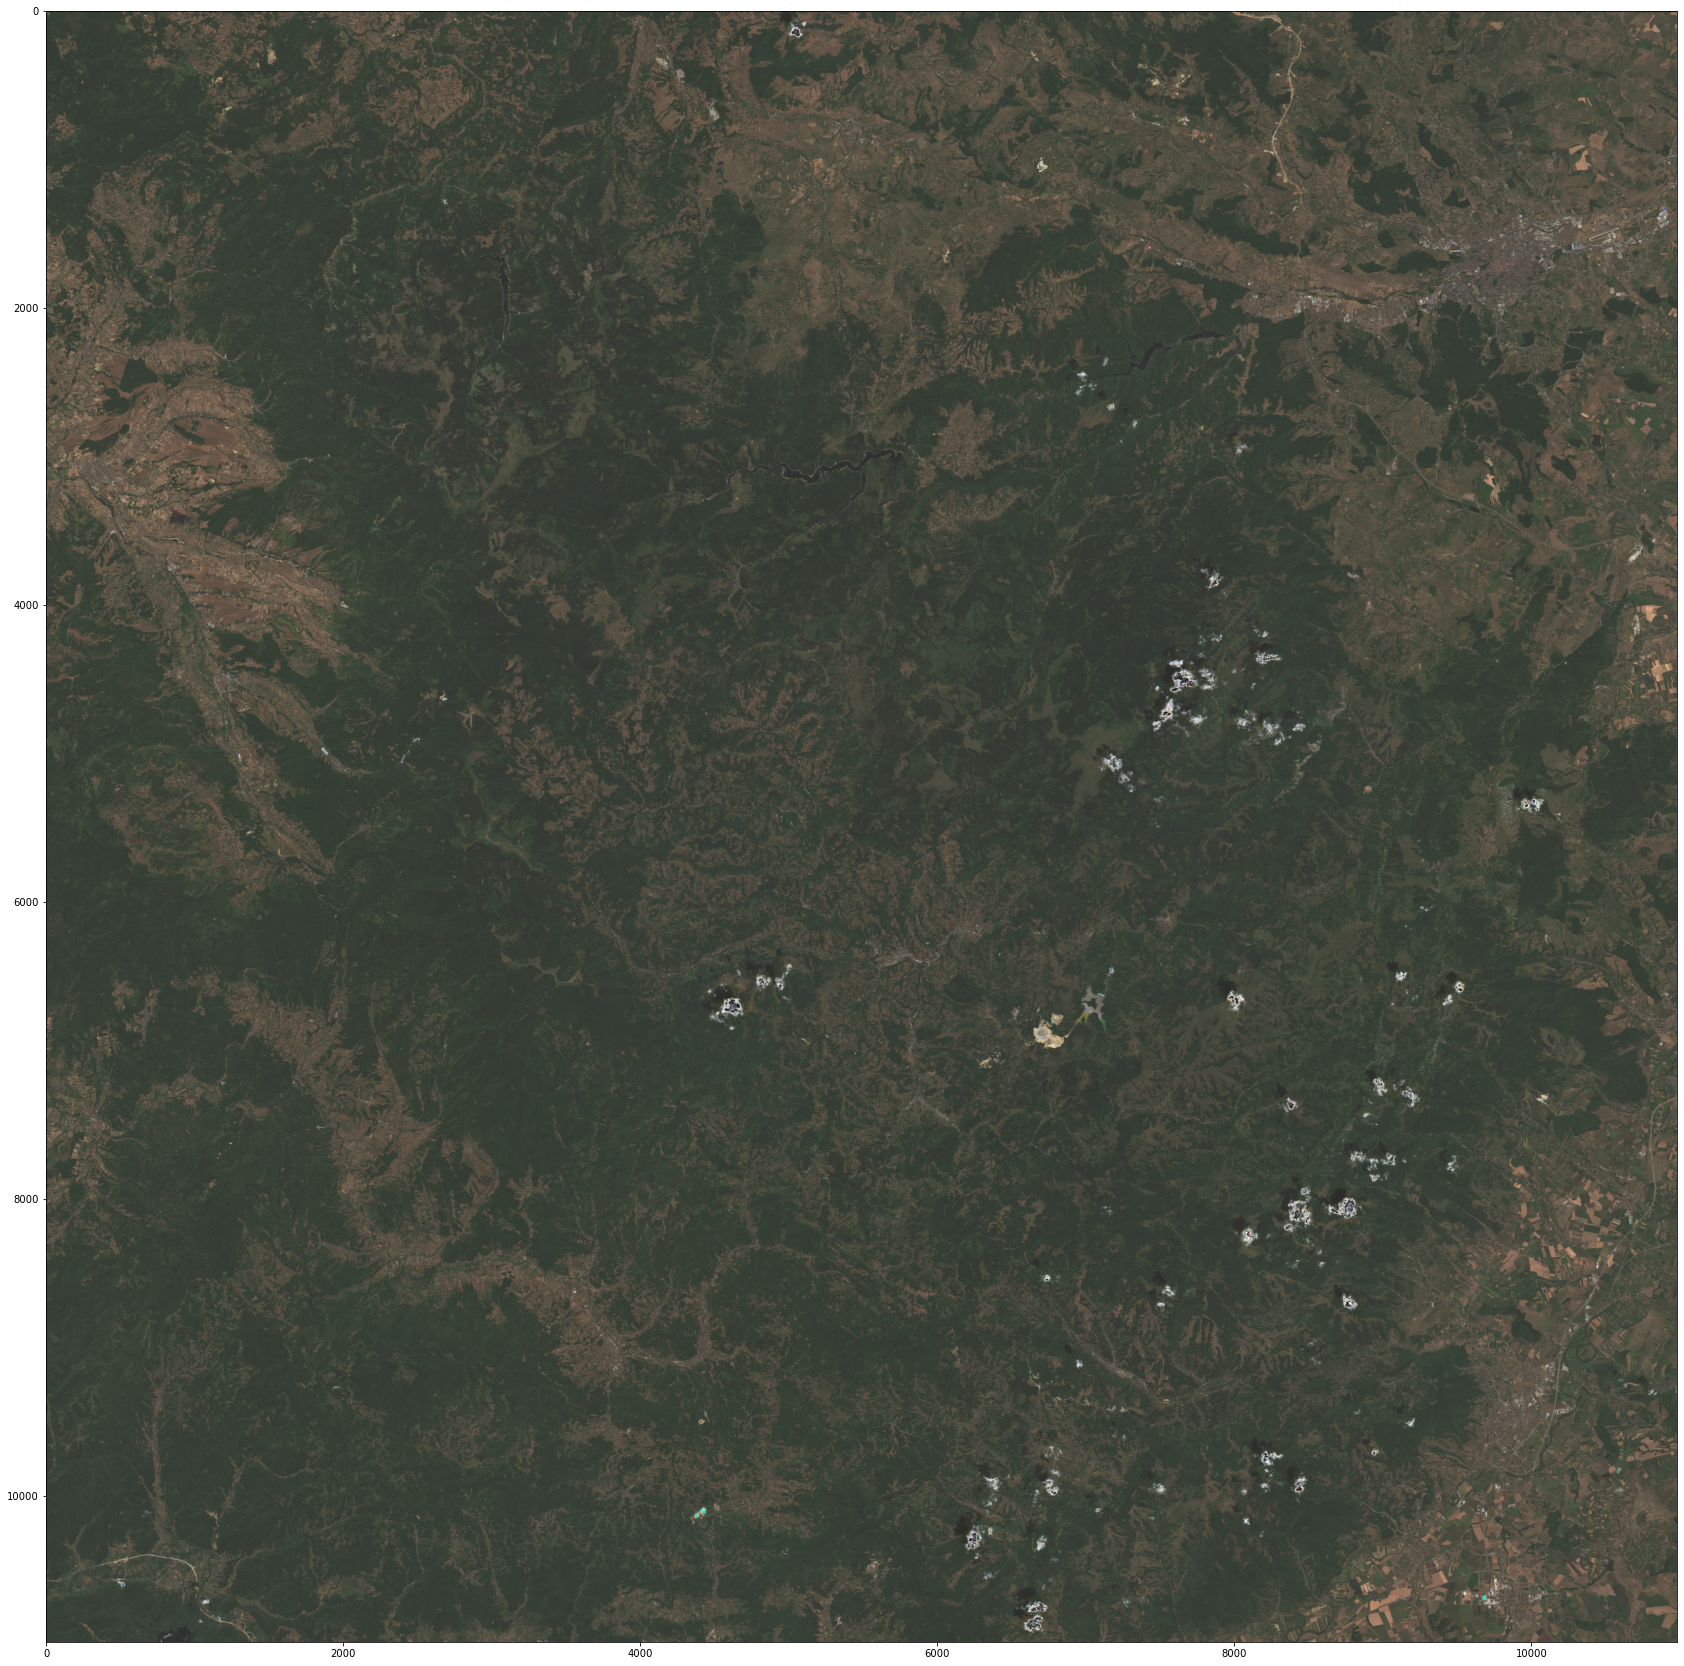

In [65]:
plt.figure(figsize = (30,30))
plt.imshow(img_processed)

In [66]:
frag_count_row = int(img_processed.shape[0] / 160)
frag_count_col = int(img_processed.shape[1] / 160)
frag_count = min(frag_count_row, frag_count_col)
frag_count

68

In [67]:
frag_count = 68

In [68]:
import re
# Use regular expression to match the pattern before .SAFE
match = re.search(r'(.*)\.SAFE', image_folder)
# Extract the matched string
image_name = match.group(1)
print(image_name)

S2A_MSIL2A_20220725T093041_N0400_R136_T34TFS_20220725T140223


In [69]:
frag_size = int(img_processed.shape[0] / frag_count)
frag_dict = {}
    
for y, x in itertools.product(range(frag_count), range(frag_count)):
    frag_dict[(x, y)] = img_processed[y*frag_size: (y+1)*frag_size,  
                                      x*frag_size: (x+1)*frag_size, :]
    frag_dict[(x, y)] = cv2.resize(frag_dict[(x, y)], (224, 224), interpolation = cv2.INTER_LANCZOS4)
    img_rgb = cv2.cvtColor(frag_dict[(x, y)], cv2.COLOR_BGR2RGB)
    frag_path  = f"fragments/fragment_{image_name}_{x}_{y}.jpg"
    cv2.imwrite(frag_path, img_rgb)  

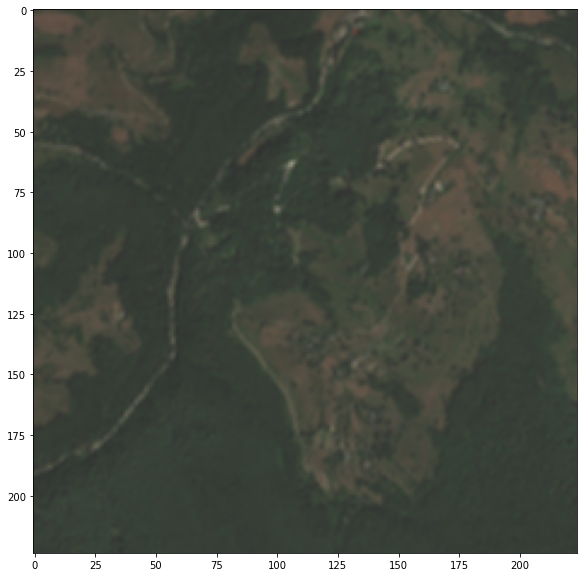

In [70]:
plt.figure(figsize = (10,10))
plt.imshow(frag_dict[(24, 34)])

In [57]:
#remove images from the fragments folder that have T35TMM in the name
for file in os.listdir("fragments"):
    if "T35TMM" in file:
        os.remove("fragments/" + file)

In [14]:
fp = 'Hansen_GFC-2021-v1.9_lossyear_50N_020E.tif'
sat = 'image_procesed.jpg'

In [15]:
import rasterio
import numpy as np
from rasterio.warp import *

# Open the Hansen image
with rasterio.open(fp) as src:
    # Read the image data into an array
    hansen_data = src.read()
    # Get the source CRS
    src_crs = src.crs
    # Get the transform matrix
    src_transform = src.transform

# Open the satellite image
with rasterio.open(sat) as dst:
    # Get the destination CRS
    dst_crs = dst.crs
    # Get the transform matrix
    dst_transform = dst.transform
    # Get the dimensions and resolution of the output image
    width, height = dst.width, dst.height
    res = dst.res


C:\Users\Lucian\AppData\Roaming\Python\Python39\site-packages\rasterio\__init__.py:334: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [ ]:

# Perform the reprojection
reproject(
    hansen_data,
    satellite_data,
    src_transform=src_transform,
    src_crs=src_crs,
    dst_transform=dst_transform,
    dst_crs=dst_crs,
    resampling=Resampling.nearest,
    width=width,
    height=height
)

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(dst_reprojected)
plt.show()